In [1]:
!pip install -U torch torchtext torchdata transformers gdown wandb --quiet

## Подключим W&B для интерактивных графиков
Ссылка на графики в описании на github


In [1]:
!wandb login

wandb: Currently logged in as: ctcf. Use `wandb login --relogin` to force relogin


## Данные


In [3]:
# membrane
!curl 'https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength%2Csequence&format=tsv&query=%28taxonomy_id%3A2%29%20AND%20%28cc_scl_term%3Amembrane%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28proteins_with%3A14%29%20AND%20%28proteins_with%3A25%29' --output membrane.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9288k    0 9288k    0     0   768k      0 --:--:--  0:00:12 --:--:--  928k


In [4]:
# cell wall + periplasm
!curl 'https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength%2Cgo_c%2Ccc_subcellular_location%2Csequence&format=tsv&query=%28taxonomy_id%3A2%29%20AND%20%28cc_scl_term%3ASL-0041%29%20OR%20%28cc_scl_term%3ASL-0200%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28proteins_with%3A14%29%20AND%20%28proteins_with%3A25%29' --output wall_periplasm.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7012k    0 7012k    0     0   691k      0 --:--:--  0:00:10 --:--:-- 1112k


In [5]:
# cytoplasm
!curl 'https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength%2Cgo_c%2Ccc_subcellular_location%2Csequence&format=tsv&query=%28taxonomy_id%3A2%29%20AND%20%28cc_scl_term%3ASL-0086%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28proteins_with%3A14%29%20AND%20%28proteins_with%3A25%29' --output cytoplasm.tsv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M    0 24.7M    0     0   644k      0 --:--:--  0:00:39 --:--:--  616k


In [6]:
# gdown https://drive.google.com/drive/folders/1ssN590vocvia0AfXKfOXQagXsKoKTBZg?usp=sharing

In [7]:
!ls

cytoplasm.tsv.gz  membrane.tsv.gz  wall_periplasm.tsv.gz
data		  sample_data	   wandb


In [8]:
!gunzip *.gz

In [9]:
!mkdir data
!mv *.tsv data

mkdir: cannot create directory ‘data’: File exists


In [4]:
%matplotlib inline
from __future__ import print_function, division
import os

import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import wandb
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Напишем класс с датасетом
- мы будем автоматически загружать все tsv файлы в формате Uniprot из папки с данными.

In [5]:
from functools import reduce

class UniprotLocationDataset(Dataset):
    """Uniprot protein subcellular location dataset."""

    def __init__(self, path, transform=None, percent_used=1.):
        """
        Args:
            path (string): directory with tsv files with protein sequences.
                each file contains proteins from one one subcellular location
                filenames will be used as classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
            percent_used (int, optional): Use only a part of data
        """

        files = os.listdir(path)
        labels = []
        seqs = []

        for f in files:
            df = pd.read_csv(os.path.join(path, f), sep='\t')
            label = f.split('.')[0]
            seqs.extend(df['Sequence'])
            labels.extend([label] * len(df))

        self.path = path

        self.seqs = np.array(seqs)
        self.labels = np.array(labels)

        self.classes = list(np.unique(self.labels))
        self.class2idx = dict(zip(self.classes, range(len(self.classes))))
        self.idx2class = dict(zip(range(len(self.classes)), self.classes))

        self.transform = transform

        max_idx = int(len(self.seqs) * percent_used)
        perm = np.random.permutation(len(labels))[:max_idx]
        self.seqs = self.seqs[perm]
        self.labels = self.labels[perm]

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.labels[idx]
        seq = self.seqs[idx]
        if self.transform:
            seq = self.transform(seq)

        return label, seq

In [6]:
dataset = UniprotLocationDataset('data/', percent_used=0.2)
print(len(dataset), dataset.classes, dataset.class2idx['membrane'])

34134 ['cytoplasm', 'membrane', 'wall_periplasm'] 1


In [7]:
total_count = len(dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count 
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (train_count, valid_count, test_count))

## Пересчитаем веса классов на трейне

In [8]:
class_weights = torch.zeros(len(dataset.classes), dtype=torch.float).to(device)
for label, _ in train_ds:
    idx = dataset.class2idx[label]
    class_weights[idx] += 1
class_weights = 1 - class_weights / class_weights.sum()
print(dataset.idx2class)
print(class_weights)

{0: 'cytoplasm', 1: 'membrane', 2: 'wall_periplasm'}
tensor([0.4068, 0.7544, 0.8388], device='cuda:0')


## Посмотрим на данные
- последовательности не сбалансированы по классам 
- последовательности отличаются по длине на 4 порядка, распределены логарифмически

### Решение:

1. мы будем использовать использовать веса по классам в функции потерь
2. мы напишем batch_sampler и collate_fn, чтобы подбирать последовательности одной длины на батч


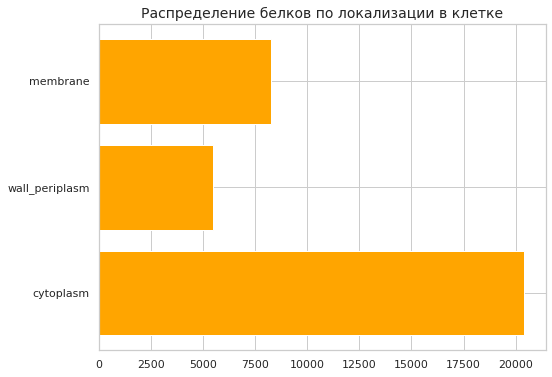

In [6]:
from collections import Counter

c = Counter(dataset.labels)

k = list(c.keys())
v = list(c.values())

plt.figure(figsize=(8, 6))
plt.barh(k, v, color='orange')
plt.title('Распределение белков по локализации в клетке', fontsize=14)
plt.show()

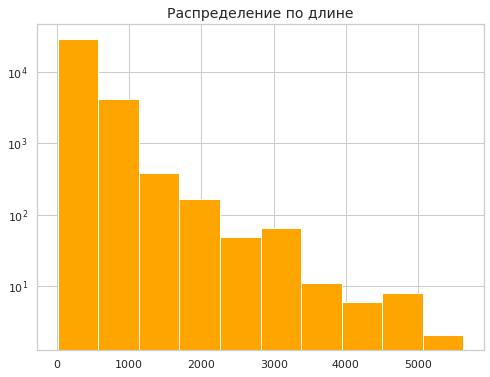

In [7]:
lens = [len(seq) for seq in dataset.seqs]
plt.figure(figsize=(8, 6))
plt.hist(lens, log=True, color='orange')
plt.title('Распределение по длине', fontsize=14)
plt.show()

In [8]:
print('Train len:', len(train_ds))
print('Train example:', train_ds[1])

Train len: 23893
Train example: ('membrane', 'MNRTKLVLGAVILGSTLLAGCSSNAKIDQLSSDVQTLNAKVDQLSNDVNAMRSDVQAAKDDAARANQRLDNQATKYRK')


Подготовим пайплайн для данных
---------------------------------
- tokenizer разбивает белковую последовательность на n-грамы. Это необходимо для того чтобы увеличить словарь и сократить количество токенов. Весь белкок кодируется всего лишь 20 (21) аминокислотами, каждая из которых представлена одной буквой, поэтому использовать n-граммы необходимо.
- составим vocab

In [9]:
def tokenizer(seq, ngram=1):
    tokens = []
    for i in range(0, len(seq), 3):
        tokens.append(seq[i:i+ngram])
    return tokens

In [10]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(dataset, ngram=1):
    for labels, seq in tqdm(dataset):
        yield tokenizer(seq, ngram=ngram)

In [11]:
vocab = build_vocab_from_iterator(yield_tokens(train_ds, ngram=3), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
len(vocab)

  0%|          | 0/23893 [00:00<?, ?it/s]

8483

In [12]:
seq_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: dataset.class2idx[x]

Baseline модель
--------------------------------
- используем nn.EmbeddingBag в качестве бейзлайн модели. EmbeddingBag усредняет все эмбеддинги и затем подаёт один эмбеддинг в линейный классификатор.
- упакуем данные внутри батча в сжатом формате для этой модели



In [13]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(seq_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [14]:
next(iter(train_dl)) ;

In [15]:
class EmbeddingBagBaseline(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [16]:
num_class = len(set([label for (label, text) in train_ds]))
vocab_size = len(vocab)
emsize = 64
model = EmbeddingBagBaseline(vocab_size, emsize, num_class).to(device)
model

EmbeddingBagBaseline(
  (embedding): EmbeddingBag(8483, 64, mode=mean)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [17]:
wandb.init(project="fiddling-with-proteins")

wandb: Currently logged in as: ctcf. Use `wandb login --relogin` to force relogin


Обучим baseline
---------------------------------------------------------




In [18]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(tqdm(dataloader, leave=True)):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        correct = (predicted_label.argmax(1) == label).sum().item()
        acc = correct / len(label)

        wandb.log({
            'train_loss': loss.item(),
            'train_acc': acc,
        })

        total_acc += correct
        total_count += label.size(0)
    return total_acc / total_count

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    loss_history, acc_history = [], []
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(tqdm(dataloader, leave=True)):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            correct = (predicted_label.argmax(1) == label).sum().item()
            total_acc += correct
            acc = correct / len(label)
            total_count += label.size(0)

            loss_history.append(loss.item())
            acc_history.append(acc)

    wandb.log({
        'valid_loss': np.array(loss_history),
        'valid_acc': np.array(acc_history),
        'valid_epoch_loss': np.array(loss_history).mean(),
        'valid_epoch_acc': np.array(acc_history).mean()
    })

    return total_acc/total_count

In [19]:
EPOCHS = 10
LR = 5e-1 
BATCH_SIZE = 64

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.2)
total_accu = None

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

wandb.config = {
    'epochs': EPOCHS,
    'initial_lr': LR,
    'batch_size': BATCH_SIZE,
    'criterion': 'CrossEntropyLoss',
    'optimizer': 'SGD',
    'scheduler': 'StepLR',
}

wandb.watch(model)


for epoch in range(1, EPOCHS + 1):
    train_acc = train(train_dl)
    valid_acc = evaluate(valid_dl)

    if total_accu is not None and total_accu > valid_acc:
      scheduler.step()
    else:
       total_accu = valid_acc
    print(f'train Acc {train_acc:.3f} | valid Acc {valid_acc:.3f}')

  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.683 | valid Acc 0.713


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.710 | valid Acc 0.706


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.714 | valid Acc 0.709


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.714 | valid Acc 0.716


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.715 | valid Acc 0.716


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.717 | valid Acc 0.715


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.715 | valid Acc 0.714


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.715 | valid Acc 0.714


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.715 | valid Acc 0.714


  0%|          | 0/374 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train Acc 0.715 | valid Acc 0.714


In [20]:
print(f'EmbeddingBag test accuracy: {evaluate(test_dl)}')

  0%|          | 0/54 [00:00<?, ?it/s]

EmbeddingBag test accuracy: 0.7039531478770131


## LSTM baseline

In [21]:
class LSTMBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        
        if bidirectional: hidden_dim *= 2

        self.pad_idx = pad_idx
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax()
        
    def forward(self, text, text_lengths):
        #text = [sent len, batch size]
        #embedded = [sent len, batch size, emb dim]
        embedded = self.embedding(text)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, enforce_sorted=False)

        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, padding_value=self.pad_idx)  

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=-1)
        hidden = self.dropout(hidden)

        x = self.fc(hidden).squeeze()
        x = self.softmax(x)
        return x

In [22]:
vocab = build_vocab_from_iterator(yield_tokens(train_ds), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])
PAD_IDX = vocab.lookup_indices(["<pad>"])[0]

  0%|          | 0/23893 [00:00<?, ?it/s]

## Подготовим данные для новой модели

## collate_fn
- сортирует и дополняет \<pad\> ами один батч

In [23]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch, padding_value=PAD_IDX):
    label_list, text_list = [], []
    for (label, seq) in batch:
        label_list.append(label_pipeline(label))
        processed_text = torch.tensor(seq_pipeline(seq))
        text_list.append(processed_text)
    text_lens = [len(s) for s in text_list]
    # labels, padded sequence, text lens
    return torch.tensor(label_list), pad_sequence(text_list, padding_value=padding_value), torch.tensor(text_lens)

## batch_sampler
- делит весь датасет на батчи по размеру

In [9]:
import random

class BatchSampler():
    def __init__(self, ds, batch_size, tokenizer):
        indices = [(i, len(tokenizer(s[1]))) for i, s in enumerate(ds)]
        random.shuffle(indices)
        pooled_indices = []

        # create pool of indices with similar lengths 
        for i in range(0, len(indices), batch_size * 100):
            pooled_indices.extend(sorted(indices[i:i + batch_size * 100], key=lambda x: x[1]))

        self.batch_size = batch_size
        self.pooled_indices = [x[0] for x in pooled_indices]
        self._len = len(self.pooled_indices) // batch_size

    def __len__(self):
        return self._len

    def __iter__(self):
        # yield indices for current batch
        for i in range(0, self._len):
            start = i*self.batch_size
            idx = self.pooled_indices[start : start+self.batch_size]
            assert len(idx) == self.batch_size
            yield idx

In [25]:
train_dl = DataLoader(train_ds, batch_sampler=BatchSampler(train_ds, BATCH_SIZE, tokenizer),
                      collate_fn=collate_batch)
valid_dl = DataLoader(valid_ds, batch_sampler=BatchSampler(valid_ds, BATCH_SIZE, tokenizer),
                      collate_fn=collate_batch)
test_dl  = DataLoader(test_ds, batch_sampler=BatchSampler(test_ds, BATCH_SIZE, tokenizer),
                      collate_fn=collate_batch)

In [26]:
from types import SimpleNamespace

config = {
    'vocab_size': len(vocab),
    'emb_dim': 100,
    'hidden_dim': 256,
    'output_dim': 3,
    'n_layers': 2,
    'bidirectional': True,
    'dropout': 0.2,
    'PAD_IDX': vocab.lookup_indices(["<pad>"])[0],
    'patience': 5,
    'initial_lr': 2e-5,
    'max_epochs': 20,
    'optimizer': 'Adam',
}

c = SimpleNamespace(**config)

In [27]:
model = LSTMBaseline(
    vocab_size=c.vocab_size,
    embedding_dim=c.emb_dim,
    hidden_dim=c.hidden_dim,
    output_dim=c.output_dim,
    n_layers=c.n_layers,
    bidirectional=c.bidirectional,
    dropout=c.dropout,
    pad_idx=c.PAD_IDX
)

lr = 2e-5
max_epochs = 20

model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), c.initial_lr)
scheduler = None#torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.1)

In [28]:
wandb.init(project="fiddling-with-proteins")

train_acc,▁▄▇▇▇█▆▅▇▇▃▇▅▆▇▇▅▅▅▄▅▅▅▄▇▅▆▆▆▅▆▅▆▆▅▆█▆█▅
train_loss,█▆▄▄▂▃▂▄▄▄▄▂▄▂▃▃▃▂▄▃▃▃▃▃▃▂▃▃▂▃▁▃▃▂▂▂▁▃▁▂
valid_epoch_acc,▆▂▄██▇▇▇▇▇▁
valid_epoch_loss,█▂▁▁▁▁▁▁▁▁▃
train_acc,0.47619
train_loss,0.84424
valid_epoch_acc,0.70334
valid_epoch_loss,0.73842


In [29]:
wandb.config = config
wandb.watch(model)

[]

In [30]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(train_dl, leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in enumerate(pbar):
        features = batch[1].to(device)
        text_lengths = batch[2].cpu()
        targets = batch[0].to(device)

        optimizer.zero_grad()
        preds = model(features, text_lengths)
        loss = criterion(preds, targets)
        acc = sum(preds.argmax(dim=1) == targets) / len(targets)

        wandb.log({
            'train_loss': loss.item(),
            'train_acc': acc,
        })

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_description(f"Epoch {epoch}. Train Loss: {loss:.4}, Train Acc: {acc:.4}")
    if scheduler is not None:
        scheduler.step()

    train_loss /= len(train_ds)
    val_loss = 0.0

    model.eval()
    pbar = tqdm(valid_dl, leave=False)
    pbar.set_description(f"Epoch {epoch}")

    val_loss = 0
    mean_acc = 0

    loss_history, acc_history = [], []
    with torch.no_grad():
        for it, batch in enumerate(pbar):
            features = batch[1].to(device)
            text_lengths = batch[2].cpu()
            targets = batch[0].to(device)

            preds = model(features, text_lengths)
            loss = criterion(preds, targets)
            acc = sum(preds.argmax(dim=1) == targets) / len(targets)

            loss_history.append(loss.item())
            acc_history.append(acc.item())

            val_loss += loss.item()
            mean_acc += acc.item()

            pbar.set_description(f"Valid Loss: {loss:.4}, Valid Acc: {acc:.4}")

    wandb.log({
        'valid_loss': np.array(loss_history),
        'valid_acc': np.array(acc_history),
        'valid_epoch_loss': np.array(loss_history).mean(),
        'valid_epoch_acc': np.array(acc_history).mean()
    })

    print(f"Valid Loss: {val_loss / len(valid_dl):.4}, Valid Acc: {mean_acc/len(valid_dl):.4}")

    val_loss /= len(valid_dl)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == c.patience:
            cur_patience = 0
            break

    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
#model.load_state_dict(best_model)

  0%|          | 0/373 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 1.046, Valid Acc: 0.5935
Epoch: 1, Training Loss: 0.016755160142152718, Validation Loss: 1.046043169385982


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.9867, Valid Acc: 0.5568
Epoch: 2, Training Loss: 0.015719076962268045, Validation Loss: 0.9867017066703653


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.9794, Valid Acc: 0.5747
Epoch: 3, Training Loss: 0.014739064592427627, Validation Loss: 0.9794397955795504


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.925, Valid Acc: 0.689
Epoch: 4, Training Loss: 0.014784463626515275, Validation Loss: 0.9250351949682776


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.9322, Valid Acc: 0.7036
Epoch: 5, Training Loss: 0.01443701288736326, Validation Loss: 0.9322152160248667


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8907, Valid Acc: 0.7218
Epoch: 6, Training Loss: 0.014173465286388676, Validation Loss: 0.8906845855263045


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8738, Valid Acc: 0.7347
Epoch: 7, Training Loss: 0.013803334222773701, Validation Loss: 0.8737925830877052


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8585, Valid Acc: 0.7282
Epoch: 8, Training Loss: 0.013525878009034577, Validation Loss: 0.8585474834127246


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8372, Valid Acc: 0.7568
Epoch: 9, Training Loss: 0.013184129919886255, Validation Loss: 0.8371670493539775


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8355, Valid Acc: 0.7549
Epoch: 10, Training Loss: 0.012998250189579102, Validation Loss: 0.8355327063011673


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8273, Valid Acc: 0.7481
Epoch: 11, Training Loss: 0.012902314437017951, Validation Loss: 0.8273232967223761


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8096, Valid Acc: 0.7801
Epoch: 12, Training Loss: 0.012655913076419516, Validation Loss: 0.809569424053408


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8059, Valid Acc: 0.7802
Epoch: 13, Training Loss: 0.012608414443586069, Validation Loss: 0.8058611446956419


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8224, Valid Acc: 0.7774
Epoch: 14, Training Loss: 0.012633426424019385, Validation Loss: 0.8224229739522034


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8063, Valid Acc: 0.7857
Epoch: 15, Training Loss: 0.012489036535730778, Validation Loss: 0.8062642525951818


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8244, Valid Acc: 0.7485
Epoch: 16, Training Loss: 0.012898640530249006, Validation Loss: 0.8244314913479787


  0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Valid Loss: 0.8072, Valid Acc: 0.7873


In [31]:
model.eval()
pbar = tqdm(test_dl, leave=False)
acc = 0
val_loss = 0
mean_acc = 0

with torch.no_grad():
    for it, batch in enumerate(pbar):
        features = batch[1].to(device)
        text_lengths = batch[2].cpu()
        targets = batch[0].to(device)

        preds = model(features, text_lengths)
        loss = criterion(preds, targets)
        acc = sum(preds.argmax(dim=1) == targets) / len(targets)

        val_loss += loss.item()
        mean_acc += acc.item()

        pbar.set_description(f"Test Loss: {loss:.4}, Test Acc: {acc:.4}")

print(f"Test Loss: {val_loss / len(test_dl):.4}, Test Acc: {mean_acc/len(test_dl):.4}")

  0%|          | 0/53 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.805, Test Acc: 0.796


---

## Классификатор на основе ProtBERT
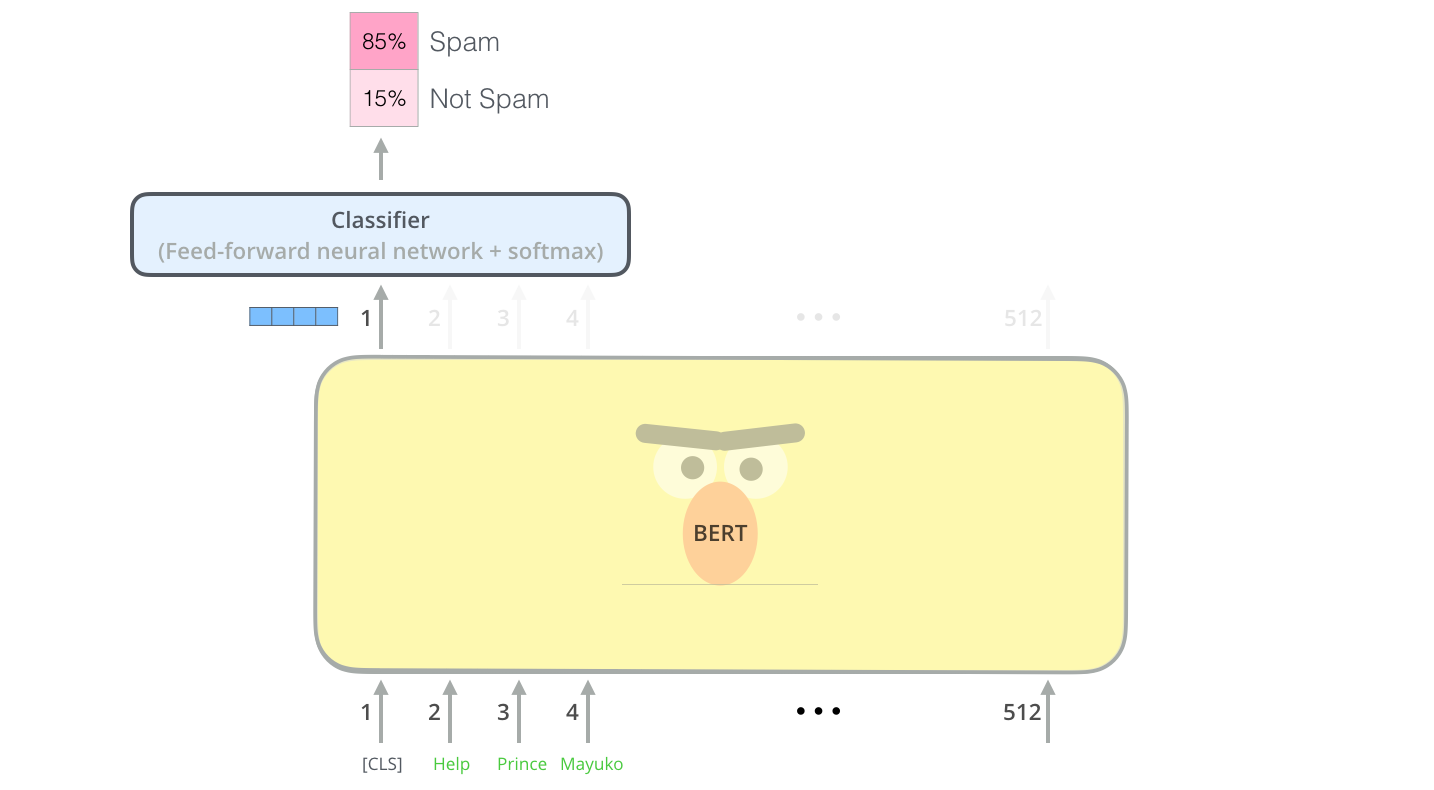

```
@article {Elnaggar2020.07.12.199554,
    author = {Elnaggar, Ahmed and Heinzinger, Michael and Dallago, Christian and Rehawi, Ghalia and Wang, Yu and Jones, Llion and Gibbs, Tom and Feher, Tamas and Angerer, Christoph and Steinegger, Martin and BHOWMIK, DEBSINDHU and Rost, Burkhard},
    title = {ProtTrans: Towards Cracking the Language of Life{\textquoteright}s Code Through Self-Supervised Deep Learning and High Performance Computing},
    elocation-id = {2020.07.12.199554},
    year = {2020},
    doi = {10.1101/2020.07.12.199554},
    publisher = {Cold Spring Harbor Laboratory},
    abstract = {Computational biology and bioinformatics provide vast data gold-mines from protein sequences, ideal for Language Models (LMs) taken from Natural Language Processing (NLP). These LMs reach for new prediction frontiers at low inference costs. Here, we trained two auto-regressive language models (Transformer-XL, XLNet) and two auto-encoder models (Bert, Albert) on data from UniRef and BFD containing up to 393 billion amino acids (words) from 2.1 billion protein sequences (22- and 112 times the entire English Wikipedia). The LMs were trained on the Summit supercomputer at Oak Ridge National Laboratory (ORNL), using 936 nodes (total 5616 GPUs) and one TPU Pod (V3-512 or V3-1024). We validated the advantage of up-scaling LMs to larger models supported by bigger data by predicting secondary structure (3-states: Q3=76-84, 8 states: Q8=65-73), sub-cellular localization for 10 cellular compartments (Q10=74) and whether a protein is membrane-bound or water-soluble (Q2=89). Dimensionality reduction revealed that the LM-embeddings from unlabeled data (only protein sequences) captured important biophysical properties governing protein shape. This implied learning some of the grammar of the language of life realized in protein sequences. The successful up-scaling of protein LMs through HPC to larger data sets slightly reduced the gap between models trained on evolutionary information and LMs. Availability ProtTrans: \&lt;a href="https://github.com/agemagician/ProtTrans"\&gt;https://github.com/agemagician/ProtTrans\&lt;/a\&gt;Competing Interest StatementThe authors have declared no competing interest.},
    URL = {https://www.biorxiv.org/content/early/2020/07/21/2020.07.12.199554},
    eprint = {https://www.biorxiv.org/content/early/2020/07/21/2020.07.12.199554.full.pdf},
    journal = {bioRxiv}
}
```

In [10]:
seq_pipeline_bert = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: dataset.class2idx[x]

def collate_batch_bert(batch):
    labels = [ label_pipeline(label) for label, _ in batch ]
    seqs = [ seq[:360] for _, seq in batch ]
    seqs = [ ' '.join(list(s)) for s in seqs ]
    inputs = tokenizer_bert(seqs, return_tensors='pt', padding=True, max_length=360)
    inputs.pop('token_type_ids')



    labels = torch.tensor(labels, dtype=torch.long)
    return labels, inputs

In [11]:
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

class ProteinClassifier(nn.Module):
    def __init__(self, n_classes):
        super(ProteinClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('yarongef/DistilProtBert')
        self.fc = nn.Sequential(nn.Dropout(p=0.2),
                                        nn.Linear(self.bert.config.hidden_size, n_classes),
                                        nn.Tanh())
        
    def forward(self, input_ids, attention_mask):
        output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        return self.fc(output.pooler_output)

In [12]:
tokenizer_bert = AutoTokenizer.from_pretrained("yarongef/DistilProtBert", do_lower_case=False )

model = ProteinClassifier(len(dataset.classes))
model.to(device)
model ;

Some weights of the model checkpoint at yarongef/DistilProtBert were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at yarongef/DistilProtBert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weig

In [13]:
wandb.init(project="fiddling-with-proteins")

wandb: Currently logged in as: ctcf. Use `wandb login --relogin` to force relogin


In [15]:
from types import SimpleNamespace

config = {
    'initial_lr': 5e-6,
    'n_warmup': 1000,
    'n_train': 10000,
    'batch_size': 16,
    'max_epoch': 2,
    'clip': 1
}

c = SimpleNamespace(**config)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=c.initial_lr)
scheduler = get_linear_schedule_with_warmup(optimizer, c.n_warmup, c.n_train)

In [16]:
train_dl = DataLoader(train_ds, batch_sampler=BatchSampler(train_ds, c.batch_size, lambda x: list(x)),
                      collate_fn=collate_batch_bert)
valid_dl = DataLoader(valid_ds, batch_sampler=BatchSampler(valid_ds, c.batch_size, lambda x: list(x)),
                      collate_fn=collate_batch_bert)
test_dl  = DataLoader(test_ds, batch_sampler=BatchSampler(test_ds, c.batch_size, lambda x: list(x)),
                      collate_fn=collate_batch_bert)

In [17]:
wandb.config = config
wandb.watch(model)

[]

In [18]:
min_loss = np.inf

cur_patience = 0

for epoch in range(1, c.max_epoch + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(train_dl, leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in enumerate(pbar):
        inputs = batch[1].to(device)
        targets = batch[0].to(device)

        optimizer.zero_grad()
        preds = model(**inputs)
        loss = criterion(preds, targets)
        acc = sum(preds.argmax(dim=1) == targets) / len(targets)

        wandb.log({
            'train_loss': loss.item(),
            'train_acc': acc,
        })

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), c.clip)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        pbar.set_description(f"Epoch {epoch}. Train Loss: {loss:.4}, Train Acc: {acc:.4}")

    train_loss /= len(train_ds)
    val_loss = 0.0

    model.eval()
    pbar = tqdm(valid_dl, leave=False)
    pbar.set_description(f"Epoch {epoch}")

    val_loss = 0
    mean_acc = 0

    loss_history, acc_history = [], []
    with torch.no_grad():
        for it, batch in enumerate(pbar):
            inputs = batch[1].to(device)
            targets = batch[0].to(device)

            preds = model(**inputs)
            loss = criterion(preds, targets)
            acc = sum(preds.argmax(dim=1) == targets) / len(targets)

            loss_history.append(loss.item())
            acc_history.append(acc.item())

            val_loss += loss.item()
            mean_acc += acc.item()

            pbar.set_description(f"Valid Loss: {loss:.4}, Valid Acc: {acc:.4}")

    wandb.log({
        'valid_loss': np.array(loss_history),
        'valid_acc': np.array(acc_history),
        'valid_epoch_loss': np.array(loss_history).mean(),
        'valid_epoch_acc': np.array(acc_history).mean()
    })

    print(f"Valid Loss: {val_loss / len(valid_dl):.4}, Valid Acc: {mean_acc/len(valid_dl):.4}")

    val_loss /= len(valid_dl)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == c.patience:
            cur_patience = 0
            break

    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
#model.load_state_dict(best_model)

  0%|          | 0/1493 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2318: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


  0%|          | 0/426 [00:00<?, ?it/s]

Valid Loss: 0.3406, Valid Acc: 0.924
Epoch: 1, Training Loss: 0.03842019691401626, Validation Loss: 0.34061092565037276


  0%|          | 0/1493 [00:00<?, ?it/s]

  0%|          | 0/426 [00:00<?, ?it/s]

Valid Loss: 0.2822, Valid Acc: 0.977
Epoch: 2, Training Loss: 0.0178151726529382, Validation Loss: 0.28215923034389256


In [19]:
model.eval()
pbar = tqdm(test_dl, leave=False)
pbar.set_description(f"Epoch")

val_loss = 0
mean_acc = 0

loss_history, acc_history = [], []
with torch.no_grad():
    for it, batch in enumerate(pbar):
        inputs = batch[1].to(device)
        targets = batch[0].to(device)

        preds = model(**inputs)
        loss = criterion(preds, targets)
        acc = sum(preds.argmax(dim=1) == targets) / len(targets)

        loss_history.append(loss.item())
        acc_history.append(acc)

        val_loss += loss.item()
        mean_acc += acc.item()

        pbar.set_description(f"Valid Loss: {loss:.4}, Valid Acc: {acc:.4}")

print(f"Valid Loss: {val_loss / len(valid_dl):.4}, Valid Acc: {mean_acc/len(test_dl):.4}")

  0%|          | 0/213 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2318: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  "`max_length` is ignored when `padding`=`True` and there is no truncation strategy. "


Valid Loss: 0.1427, Valid Acc: 0.9748


In [20]:
wandb.finish()

train_acc,▁▄▆▆▇▂▁▇████████▇█████████████████▇█████
train_loss,▇▇▇▆▆██▄▄▃▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▃▁▁▁▂▁
valid_epoch_acc,▁█
valid_epoch_loss,█▁
train_acc,1.0
train_loss,0.24207
valid_epoch_acc,0.97697
valid_epoch_loss,0.28216


# Результаты
## Данные
Для начала я скачал данные с белковыми последовательностями и их расположениями в клетке. Я выбрал бактериальную клетку, так как в ней есть 3 основных расположения: цитоплазма, мембрана, клеточная стенка и периплазм (пространство внутри клеточной стенки). Были выбраны из базы Uniprot, так как это курируемая база данных. Были скачаны только те последовательности белков, которые были отобраны людьми (reviewed), для которых известна их полная последовательность, известна функция. Всего было скачано 150000+ из 200000 известных бактерикальных белков, аннотированных людьми.

Был написан класс Dataset, для загрузки последовательностей. Визуализировано распределение белков по классам и по длине. Для борьбы с дисбалансом по классам использовались веса по классам.  
EmbeddingBagBaseline и LSTMBaseline могли учиться на белках полной длины (до 10000 аминокислот), для DistilBERT пришлось обрезать белок до первых 360 аминокислот, так как иначе модель и батчи не помещалась на видеокарте.

## Сравнение моделей
Были обучены 3 модели разной сложности для классификации белков по их расположению в клетке:

- EmbeddingBagBaseline - линейный классификатор, обученный на усреднении всех эмбеддингов. Эта простая модель использовалась в качестве бейслайна и соответствует классическим подходам, до использования RNN. 
    - Точность на тесте **0.704**. (0.615 - ожидаемая точность при предсказании самого часто встречающегося класса).
    - Для обучения пришлось начать с большого lr и затем уменьшать его.
- LSTMBaseline - bidirectional LSTM, два слоя + с линейный классификатор. Мне были интересны LSTM модели, так как они активно используются в биологических лабораторих. 
    - Точность на тесте **0.796**. Несмотря на большой объём данных, точность была не намного выше чем у EmbeddingBag. 
    - Использование n-граммов с маленькими n давало похожую точность, на больших n точность падала.
- DistilProtBERT, предобученный на последовательностях белков (masking). Transformers являются самыми продвинутыми языковыми моделями. 
    - ProtBERT адаптирован для работы с белковыми последовательностями, но его оказалось невозможно эффективно обучать на колабе из-за большого размера. 
    - DistilProtBERT быстро достиг 95% точности и вышел на плато.
    - Во время обучения использовались веса по классам, AdamW, и warmup lr scheduler для того чтобы не повредить предобученную модель.
    - без `clip_grad_norm_` модель деградировала. Обрезать взрывающиеся градиенты необходимо! 
    - Точность на тесте **0.974**. Я считаю проект законченным, так как с ресурсами колаба точность больше 98% получить затруднительно.

## Вывод
- Для работы с биологическими последовательностями трансформеры являются лучшей архитектурой на данный момент. Они доступны на huggingface и по ним уже написано много статей в биологических журналах, например dnaBERT, rnaBERT итд.
- Для отдельного исследователя сейчас наиболее актуально дообучать большие языковые модели для своих данных или искать закономерности/аномалии в открытых данных, например предсказывать вероятные антибиотики, токсины или функции ферментов.

---

#### Итоговый проект 2 семестра Deep Learning School ФПМИ МФТИ

## Графики обучения

Интерактивные графики на WandB


https://wandb.ai/ctcf/fiddling-with-proteins?workspace=user-ctcf

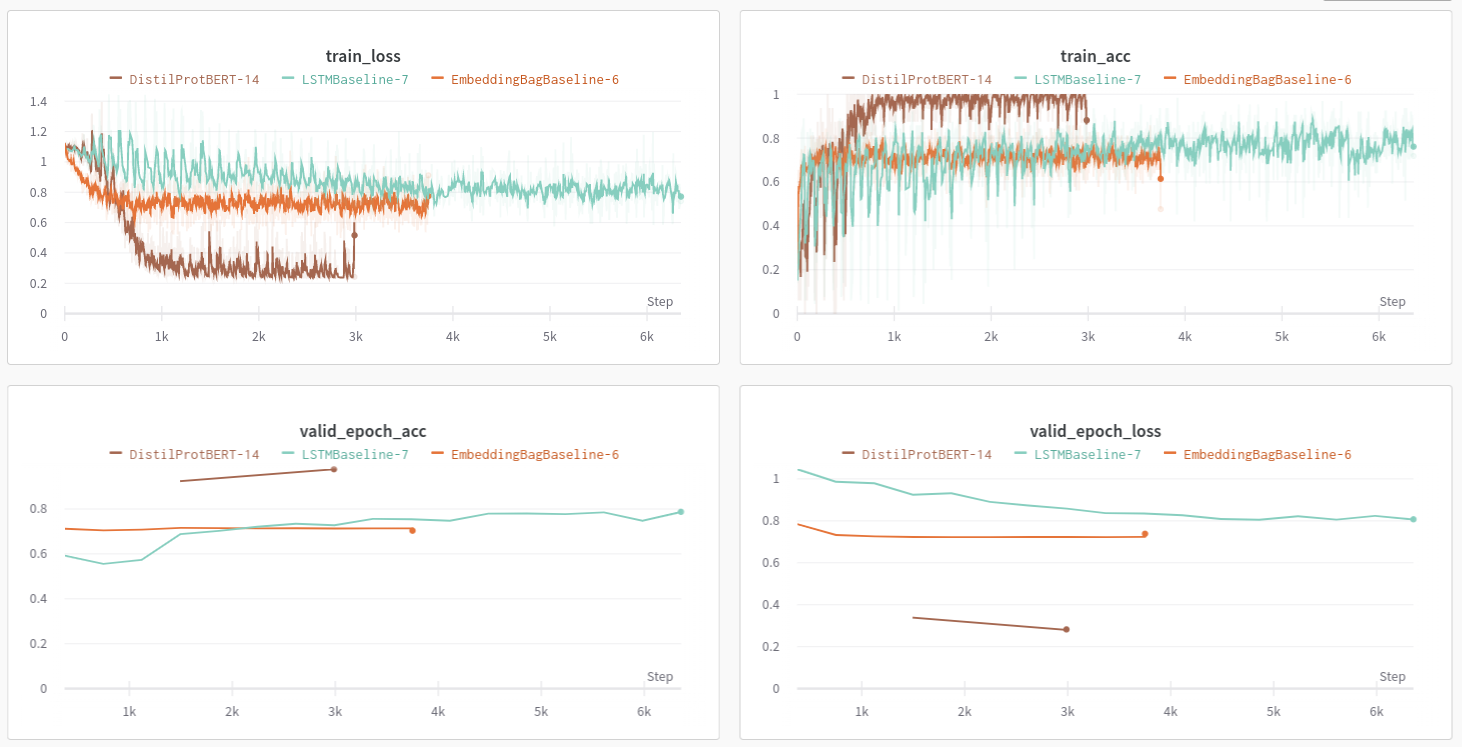